In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import sklearn.metrics

In [2]:
# make plots look pretty
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ignore unnecesary warnings
import warnings
warnings.filterwarnings('ignore')

# forecasting air passengers

we have the monthly info for air passengers of certain airline, from 1949 to 1960

In [3]:
df = pd.read_csv('air-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


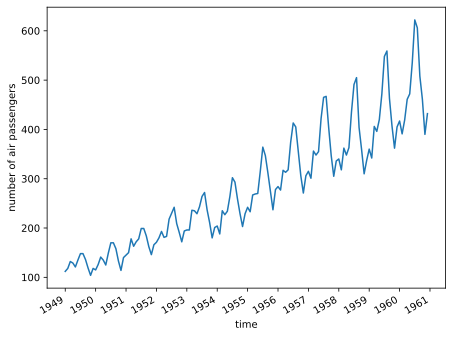

In [16]:
fig, ax = plt.subplots()

ax.plot(df.Passengers)

ax.set_xlabel('time')
ax.set_ylabel('number of air passengers')

ax.set_xticks(
    np.arange(0, 145, 12),
    np.arange(1949, 1962, 1),
)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

We can see that it seems there is a pattern that repeats every year

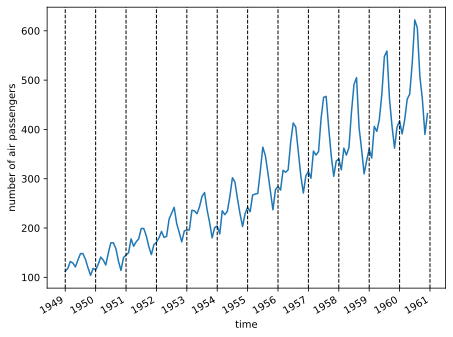

In [5]:
fig, ax = plt.subplots()

ax.plot(df.Passengers)

ax.set_xlabel('time')
ax.set_ylabel('number of air passengers')

ax.set_xticks(
    np.arange(0, 145, 12),
    np.arange(1949, 1962, 1),
)

# draw line every year
for i in np.arange(0, 145, 12):
    ax.axvline(x = i, linestyle = '--', color = 'black', linewidth = 1)
    
fig.autofmt_xdate()
plt.tight_layout()

another way of seeing the seasonability is by decomposing the time series:

In [6]:
# the period is equal to the frequency
# STL stands for Season-Trend decomposition using LOESS.
decomposition = sm.tsa.STL(df.Passengers, period = 12).fit()

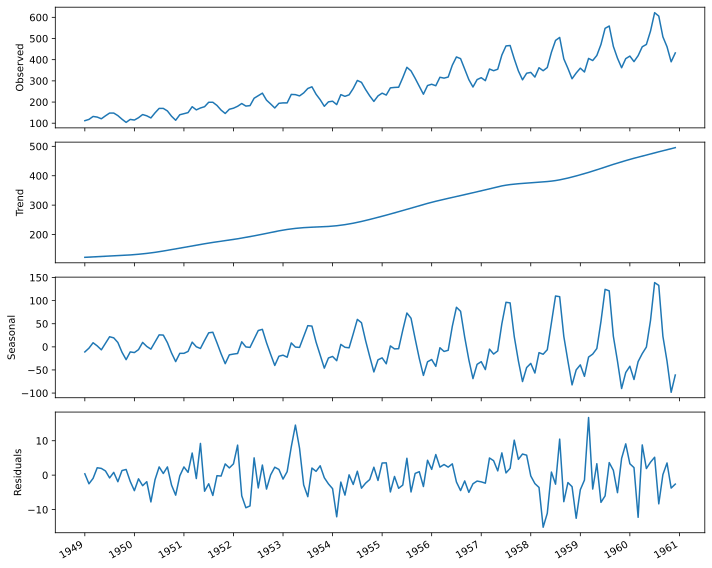

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    nrows = 4, ncols = 1, 
    sharex = True, 
    figsize=(10,8)
) 

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))


fig.autofmt_xdate()
plt.tight_layout()

plt.show()

You can see that the y-axis are diff for the four plots; this is because each plot shows the magnitude of change that is attributed to that particular component. Meaning the sum of the residuals, seasonal, and trend data become the observed data.

Well we know the drill by now, let's test for stationarity

In [9]:
adf = sm.tsa.stattools.adfuller(df.Passengers)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic 0.8153688792060421
p-value 0.9918802434376409


adf statistic is not a large negative value, and $p$ value is larger than 0.05, therefore we cannot reject the null hypothesis meaning that our time series is not stationary

I bet no one was surprised by this result, so let's see how many diff we need to apply to make it stationary.

In [13]:
passengers_diff = np.diff(df.Passengers, n = 1)
adf = sm.tsa.stattools.adfuller(passengers_diff)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -2.829266824169981
p-value 0.05421329028382792


Seems that still nope

In [14]:
passengers_diff = np.diff(df.Passengers, n = 2)
adf = sm.tsa.stattools.adfuller(passengers_diff)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -16.384231542468513
p-value 2.7328918500142026e-29


That looks more like it $p < 0.05$ so we can reject the null hypothesis meaning that our time series is now stationary and $d = 2$